***FDS Step 4***

Step 1: Derive sentiment distribution across the document

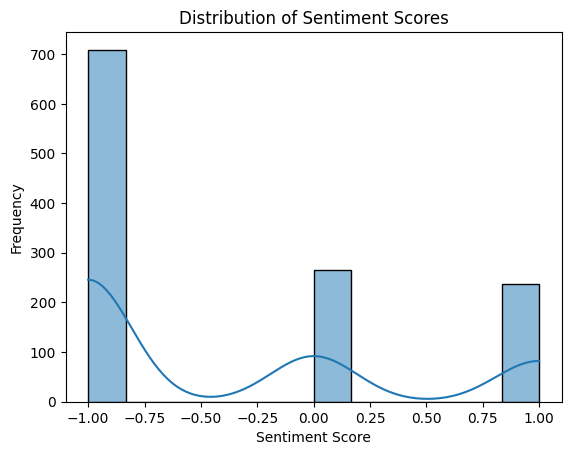

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from statsmodels.tsa.seasonal import seasonal_decompose
from wordcloud import WordCloud

# Load your CSV file
df = pd.read_excel('flop.xlsx')

# Basic Preprocessing
# Ensure that 'timestamp' is in datetime format if it exists
# df['timestamp'] = pd.to_datetime(df['timestamp'])
# Create additional features (e.g., comment length)
df['comment_length'] = df['COMMENT'].apply(len)

# --- Time Series Analysis ---
# If you have timestamp data, you can decompose the sentiment time series
if 'timestamp' in df.columns:
    df.set_index('timestamp', inplace=True)
    result = seasonal_decompose(df['LABEL'], model='additive', period=30)
    # Adjust period based on your data
    result.plot()
    plt.show()

# --- Sentiment Distribution Analysis ---
sns.histplot(df['LABEL'], kde=True)
plt.title("Distribution of Sentiment Scores")
plt.xlabel("Sentiment Score")
plt.ylabel("Frequency")
plt.show()


Step 2: Generate wordclouds

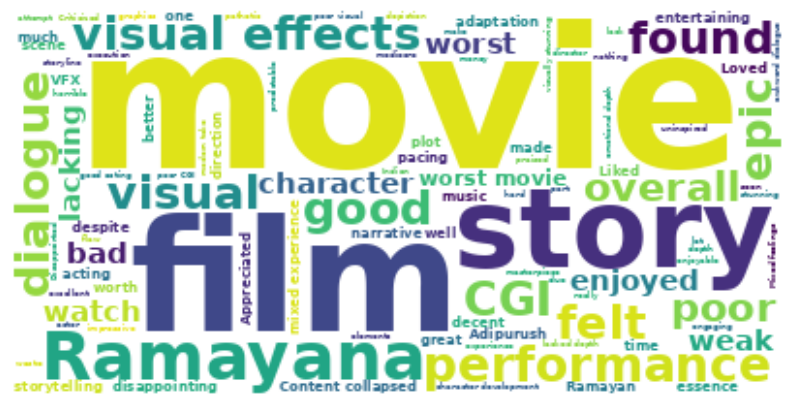

In [3]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# --- Word Cloud for Comment Analysis ---
text = " ".join(comment for comment in df['COMMENT'])

# Use the DejaVu Sans font, which is typically available on Ubuntu
font_path = "/usr/share/fonts/truetype/dejavu/DejaVuSans-Bold.ttf"

# Generate the word cloud with the correct font path
wordcloud = WordCloud(max_words=100, background_color="white", font_path=font_path).generate(text)

# Plot the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


Step 3: Perform predictive analytics

Linear Regression - Mean Squared Error: 0.6330
Decision Tree - Mean Squared Error: 0.6857
Support Vector Machine - Mean Squared Error: 0.8688
Random Forest - Mean Squared Error: 0.6728
XGBoost - Mean Squared Error: 0.6835


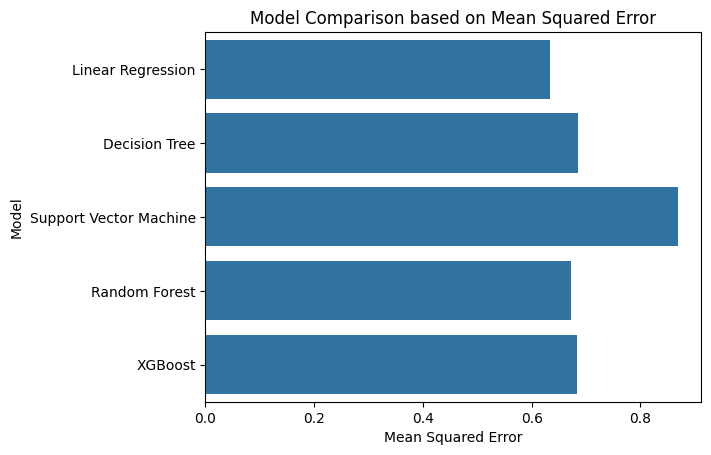

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

# Basic Preprocessing
# Ensure that 'timestamp' is in datetime format if it exists
# df['timestamp'] = pd.to_datetime(df['timestamp'])
# Create additional features (e.g., comment length)
df['comment_length'] = df['COMMENT'].apply(len)

# Select features and target
X = df[['comment_length']]
# Add other relevant features if available
y = df['LABEL']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
random_state=42)

# Initialize models
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Support Vector Machine': SVR(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'XGBoost': xgb.XGBRegressor(objective='reg:squarederror',
random_state=42)
}

# Train, predict, and evaluate each model
results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    results[name] = mse
    print(f'{name} - Mean Squared Error: {mse:.4f}')


# Compare the results
results_df = pd.DataFrame(list(results.items()), columns=['Model', 'Mean Squared Error'])
sns.barplot(x='Mean Squared Error', y='Model', data=results_df)
plt.title("Model Comparison based on Mean Squared Error")
plt.show()


Step 4: Derive the plots

a) Residual plot: A residuals plot shows the difference between the actual and predicted values. It helps to assess the model's fit.

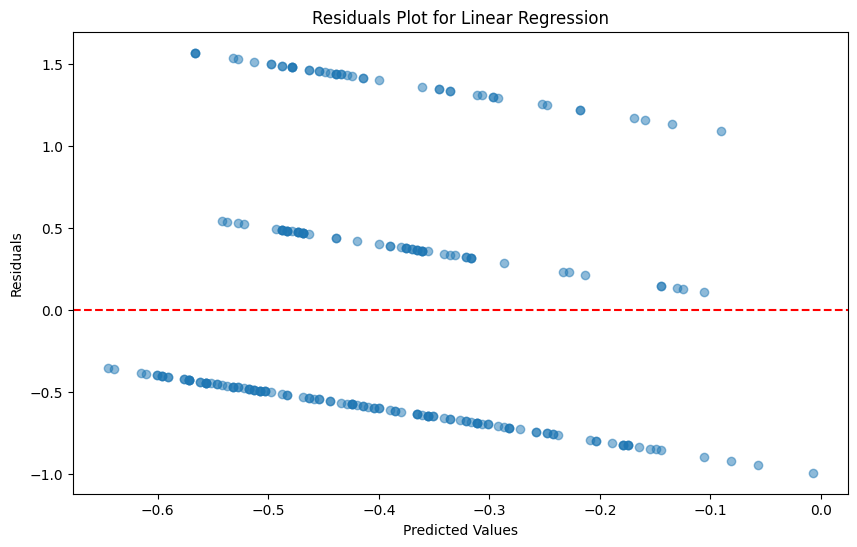

In [5]:
# Plot residuals for the best-performing model
best_model_name = min(results, key=results.get)
best_model = models[best_model_name]

# Predict and calculate residuals
y_pred = best_model.predict(X_test)
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title(f'Residuals Plot for {best_model_name}')
plt.show()

b) Predicted vs Actual plot: This plot compares predicted values to actual values, giving a visual
representation of how well the model performs.

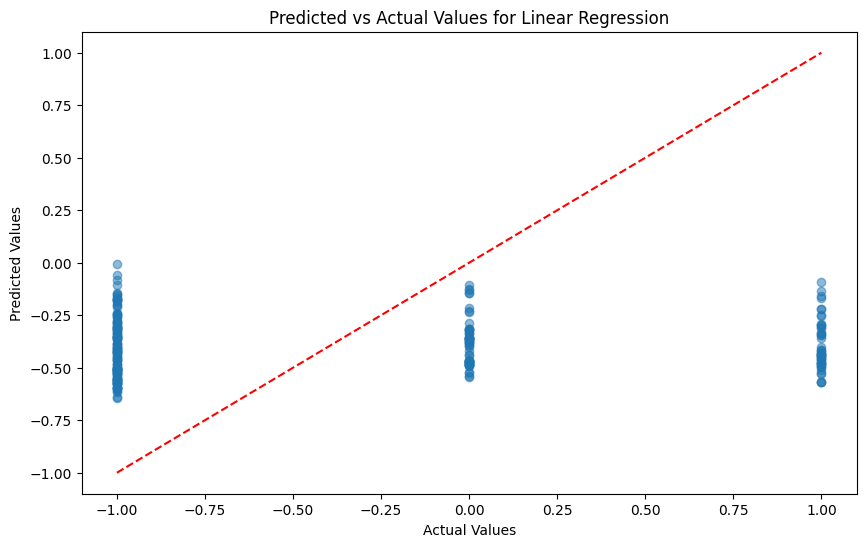

In [6]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title(f'Predicted vs Actual Values for {best_model_name}')
plt.show()

c) Learning curves: Learning curves show how the model’s performance changes with varying
amounts of training data.

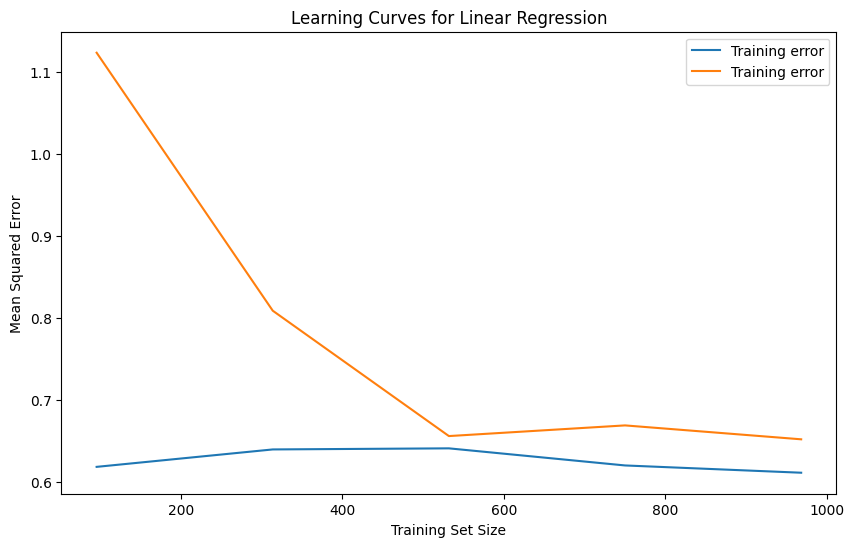

In [10]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(best_model, X, y, cv=5, scoring='neg_mean_squared_error')

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, -train_scores.mean(axis=1), label = 'Training error')
plt.plot(train_sizes, -test_scores.mean(axis=1), label = 'Training error')
plt.xlabel('Training Set Size')
plt.ylabel('Mean Squared Error')
plt.title(f'Learning Curves for {best_model_name}')
plt.legend()
plt.show()

d) Feature Distribution Plot:

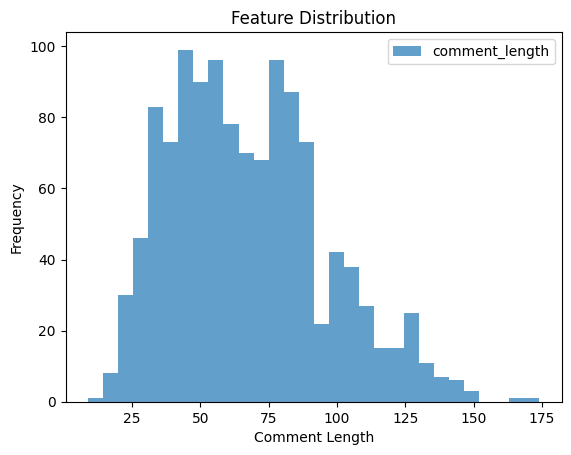

In [11]:

df[['comment_length']].plot(kind='hist', bins=30, alpha=0.7)
plt.xlabel('Comment Length')
plt.title('Feature Distribution')
plt.show()

e) Model Performance Comparison Box Plot: A box plot of cross-validation scores can help
visualize the variability in model performance

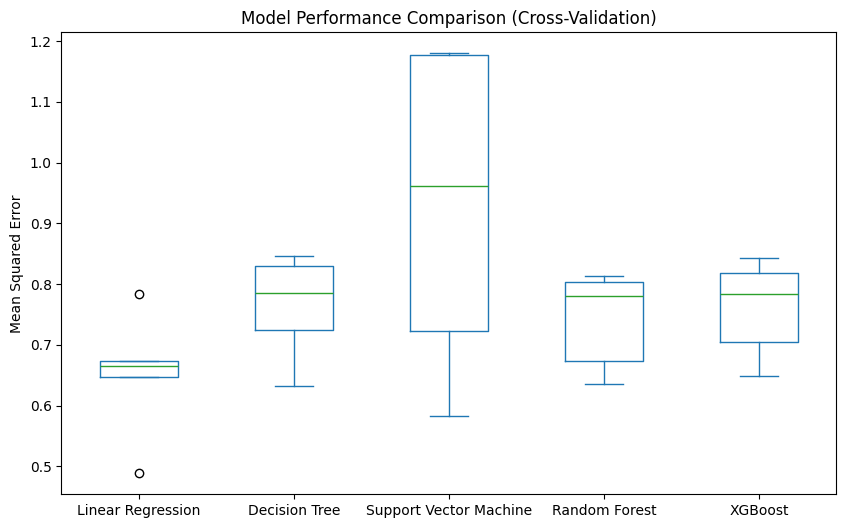

In [12]:

from sklearn.model_selection import cross_val_score

cv_results = {}

for name, model in models.items():
    scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
    cv_results[name] = -scores
    
cv_results_df = pd.DataFrame(cv_results)
cv_results_df.plot.box(figsize=(10, 6))
plt.title('Model Performance Comparison (Cross-Validation)')
plt.ylabel('Mean Squared Error')
plt.show()

f) Error Distribution Plot: Visualize the distribution of errors (residuals) to understand the error
characteristics

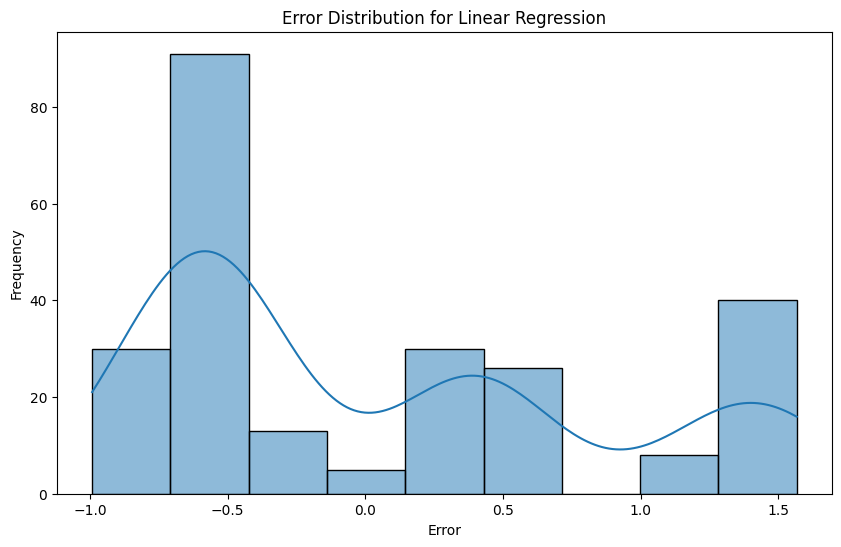

In [13]:

errors = y_test - y_pred

plt.figure(figsize=(10, 6))
sns.histplot(errors, kde=True)
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.title(f'Error Distribution for {best_model_name}')
plt.show()

Step 5: Co-occurrence network: Identify clusters of related topics or terms.

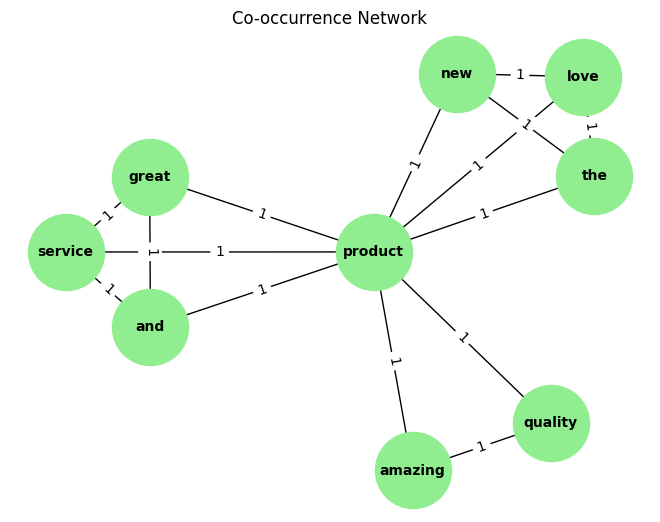

In [19]:

from sklearn.feature_extraction.text import CountVectorizer
from networkx import Graph # Example comments
import networkx as nx


comments = ['Love the new product', 'Great service and product', 'Amazing product quality']

# Create a count matrix
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(comments)
terms = vectorizer.get_feature_names_out()

# Create a co-occurrence matrix
co_occurrence = (X.T @ X).toarray()
np.fill_diagonal(co_occurrence, 0)

# Build the network
G = Graph()
for i in range(len(terms)):
    G.add_node(terms[i])
    
for i in range(len(terms)):
    for j in range(i+1, len(terms)):
        if co_occurrence[i, j] > 0:
            G.add_edge(terms[i], terms[j], weight=co_occurrence[i, j])
            
# Draw the network
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_size=3000, node_color='lightgreen', font_size=10, font_weight='bold')
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
plt.title('Co-occurrence Network')
plt.show()

In [15]:
pip install networkx


Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 1.9 MB/s eta 0:00:00 MB/s eta 0:00:01:01
Note: you may need to restart the kernel to use updated packages.
